In [1]:
import pandas as pd
import sys

sys.path.append('../')
from data.dicts.col_dict import *
from helpers.plots import *
plt.rcParams.update(rc)


/home/aas926/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [25]:
# data 
data_dir = '../results/ewas/tables/processed'
# load the files
os.listdir(data_dir)

# targets = ['fvc', 'fev1'] 
# cohorts = ['UKB', 'NH']

# groups = ['Race', 'Anthropometrics', 'Demographics', 'Exposures']
# dfs = [pd.read_csv(os.path.join(data_dir, f)) for f in os.listdir(data_dir) if f.endswith('.csv')]
# print(dfs)

# for t in targets:
#     df = pd.concat(dfs).query('cohort in @cohorts and target == @t.upper() and group in @groups')
#     print(df.group.unique())
#     display(df)
# image.png


['nh3_ref_ewas.csv', 'nh4_ref_ewas.csv', 'nh_ref_ewas.csv', 'ukb_ref_ewas.csv']

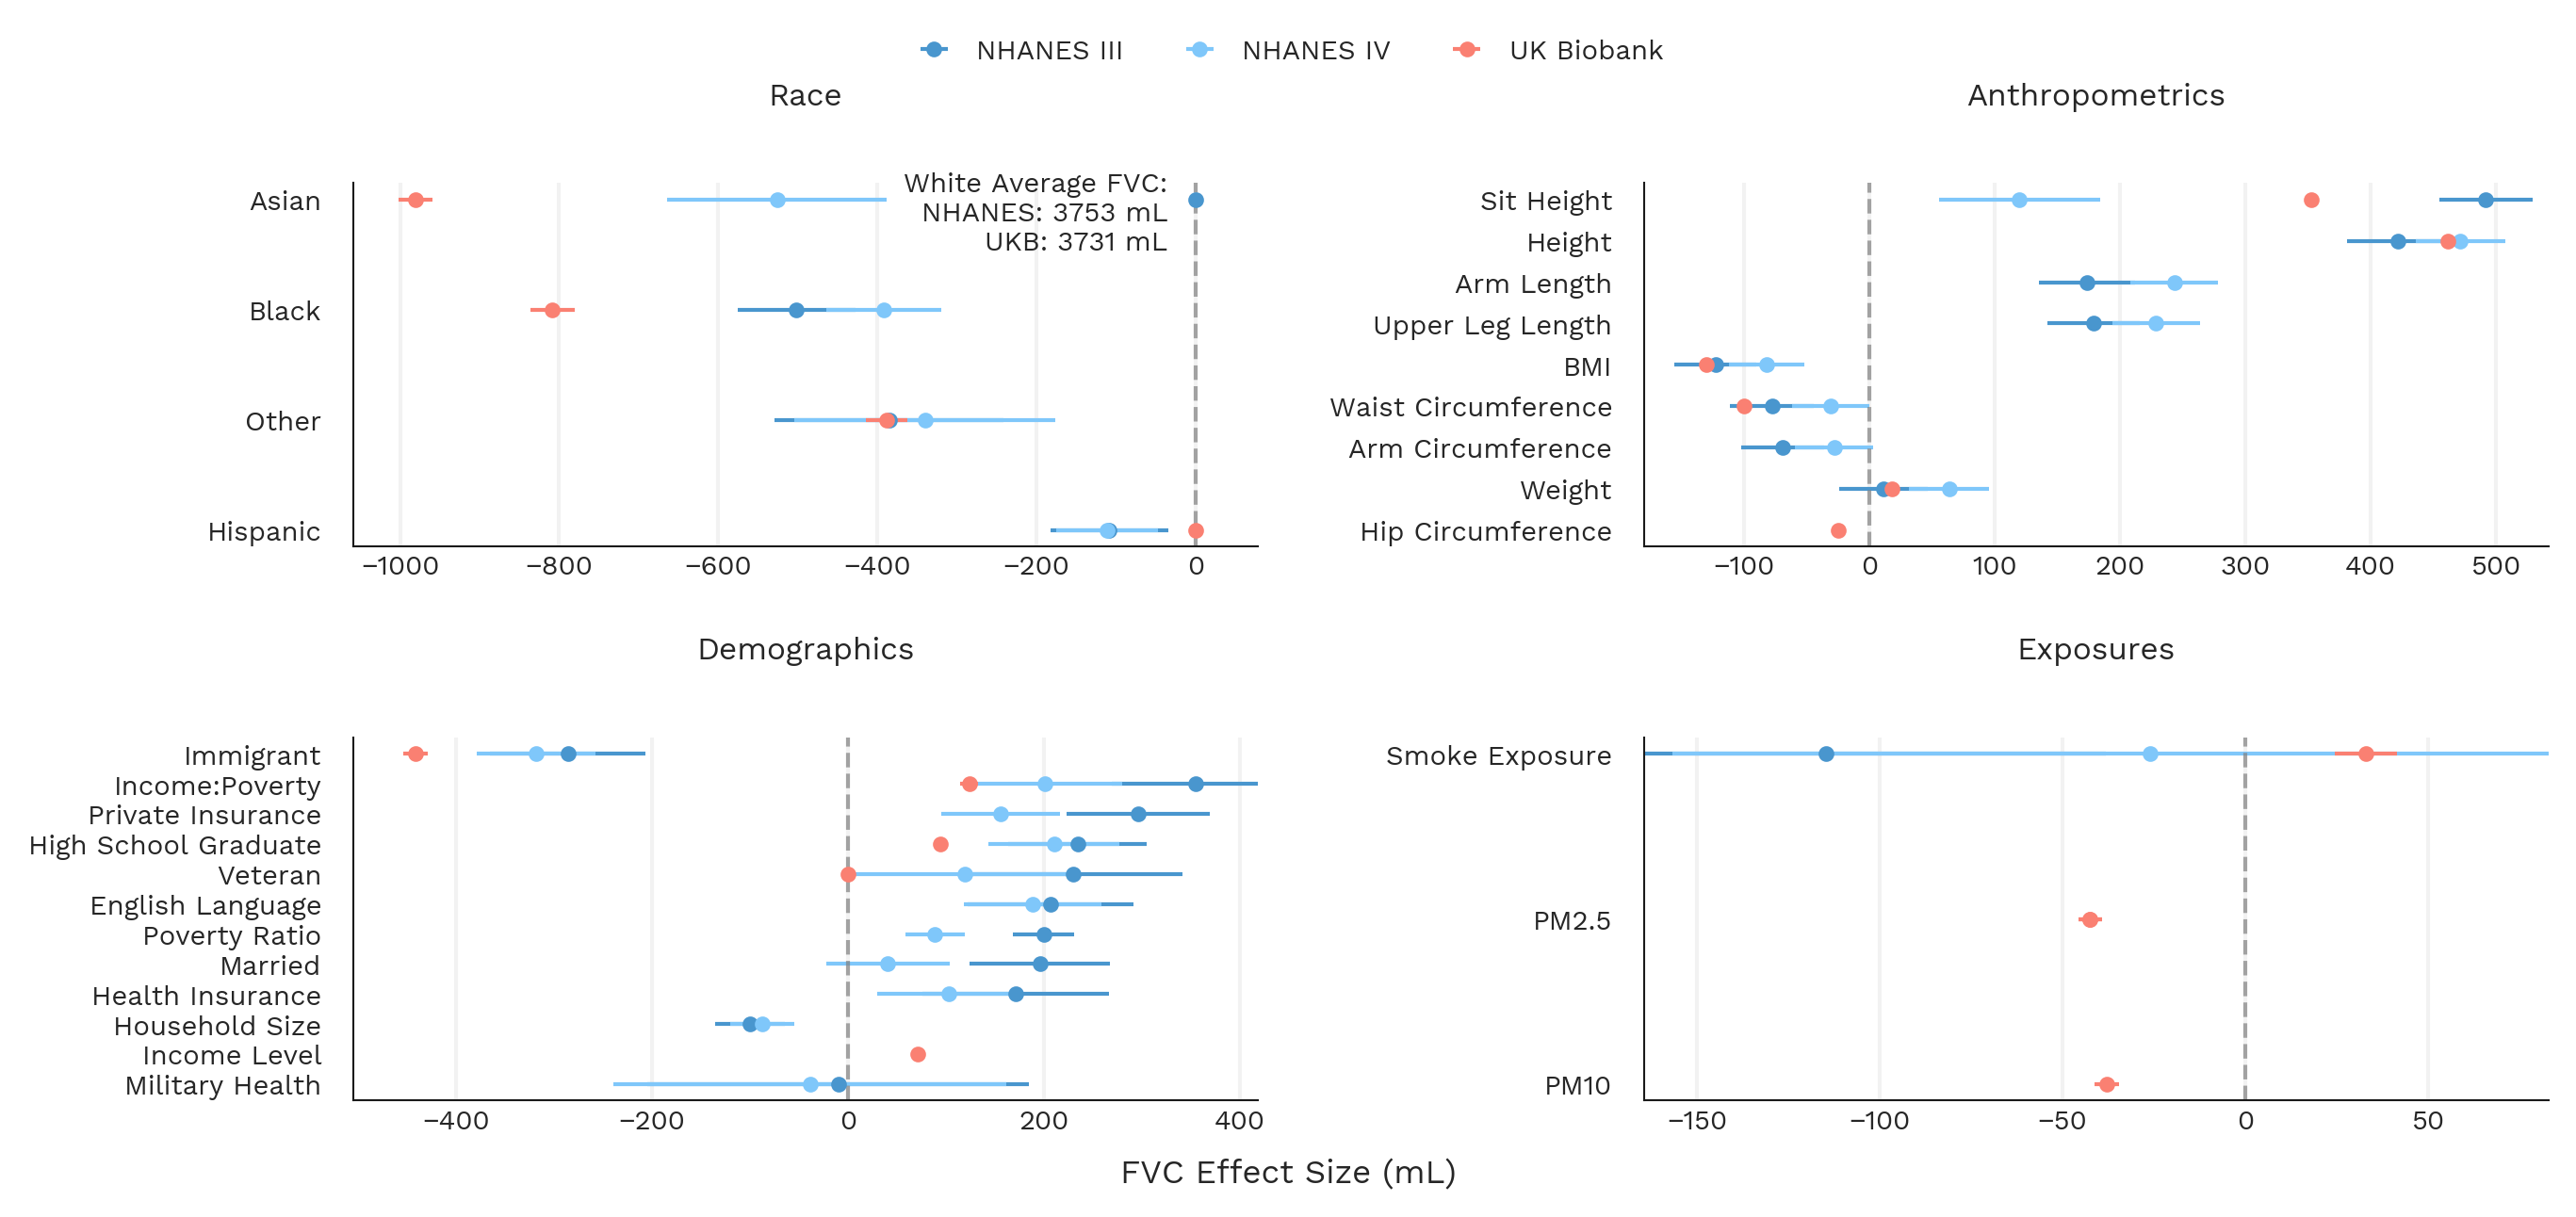

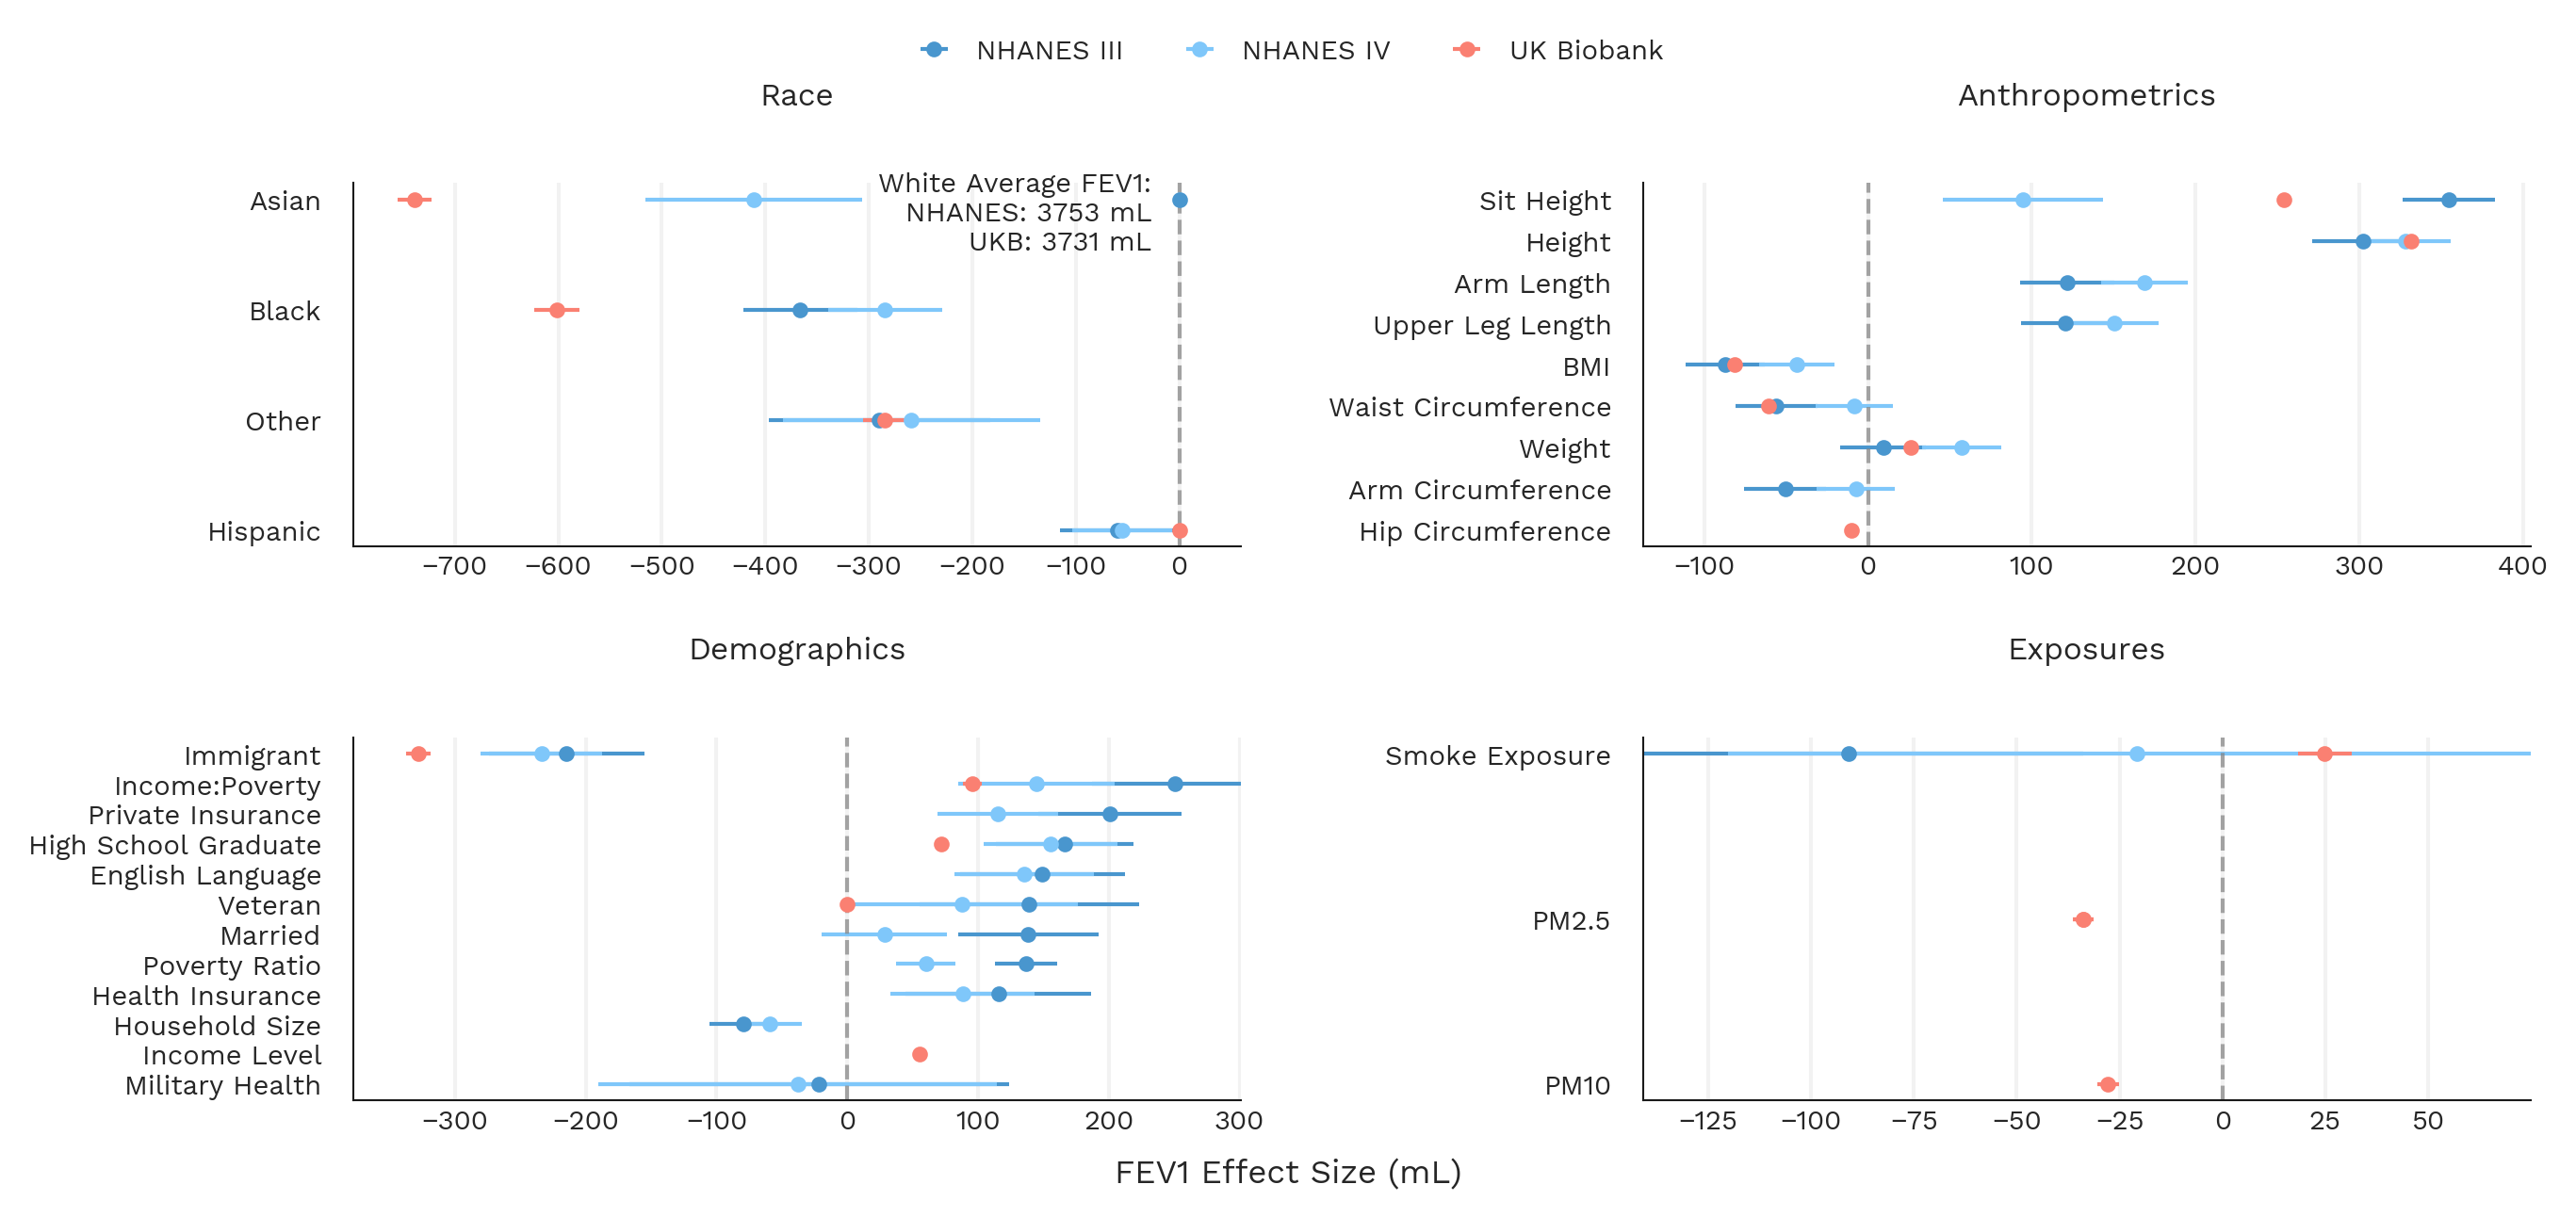

KeyError: 'nhanes'

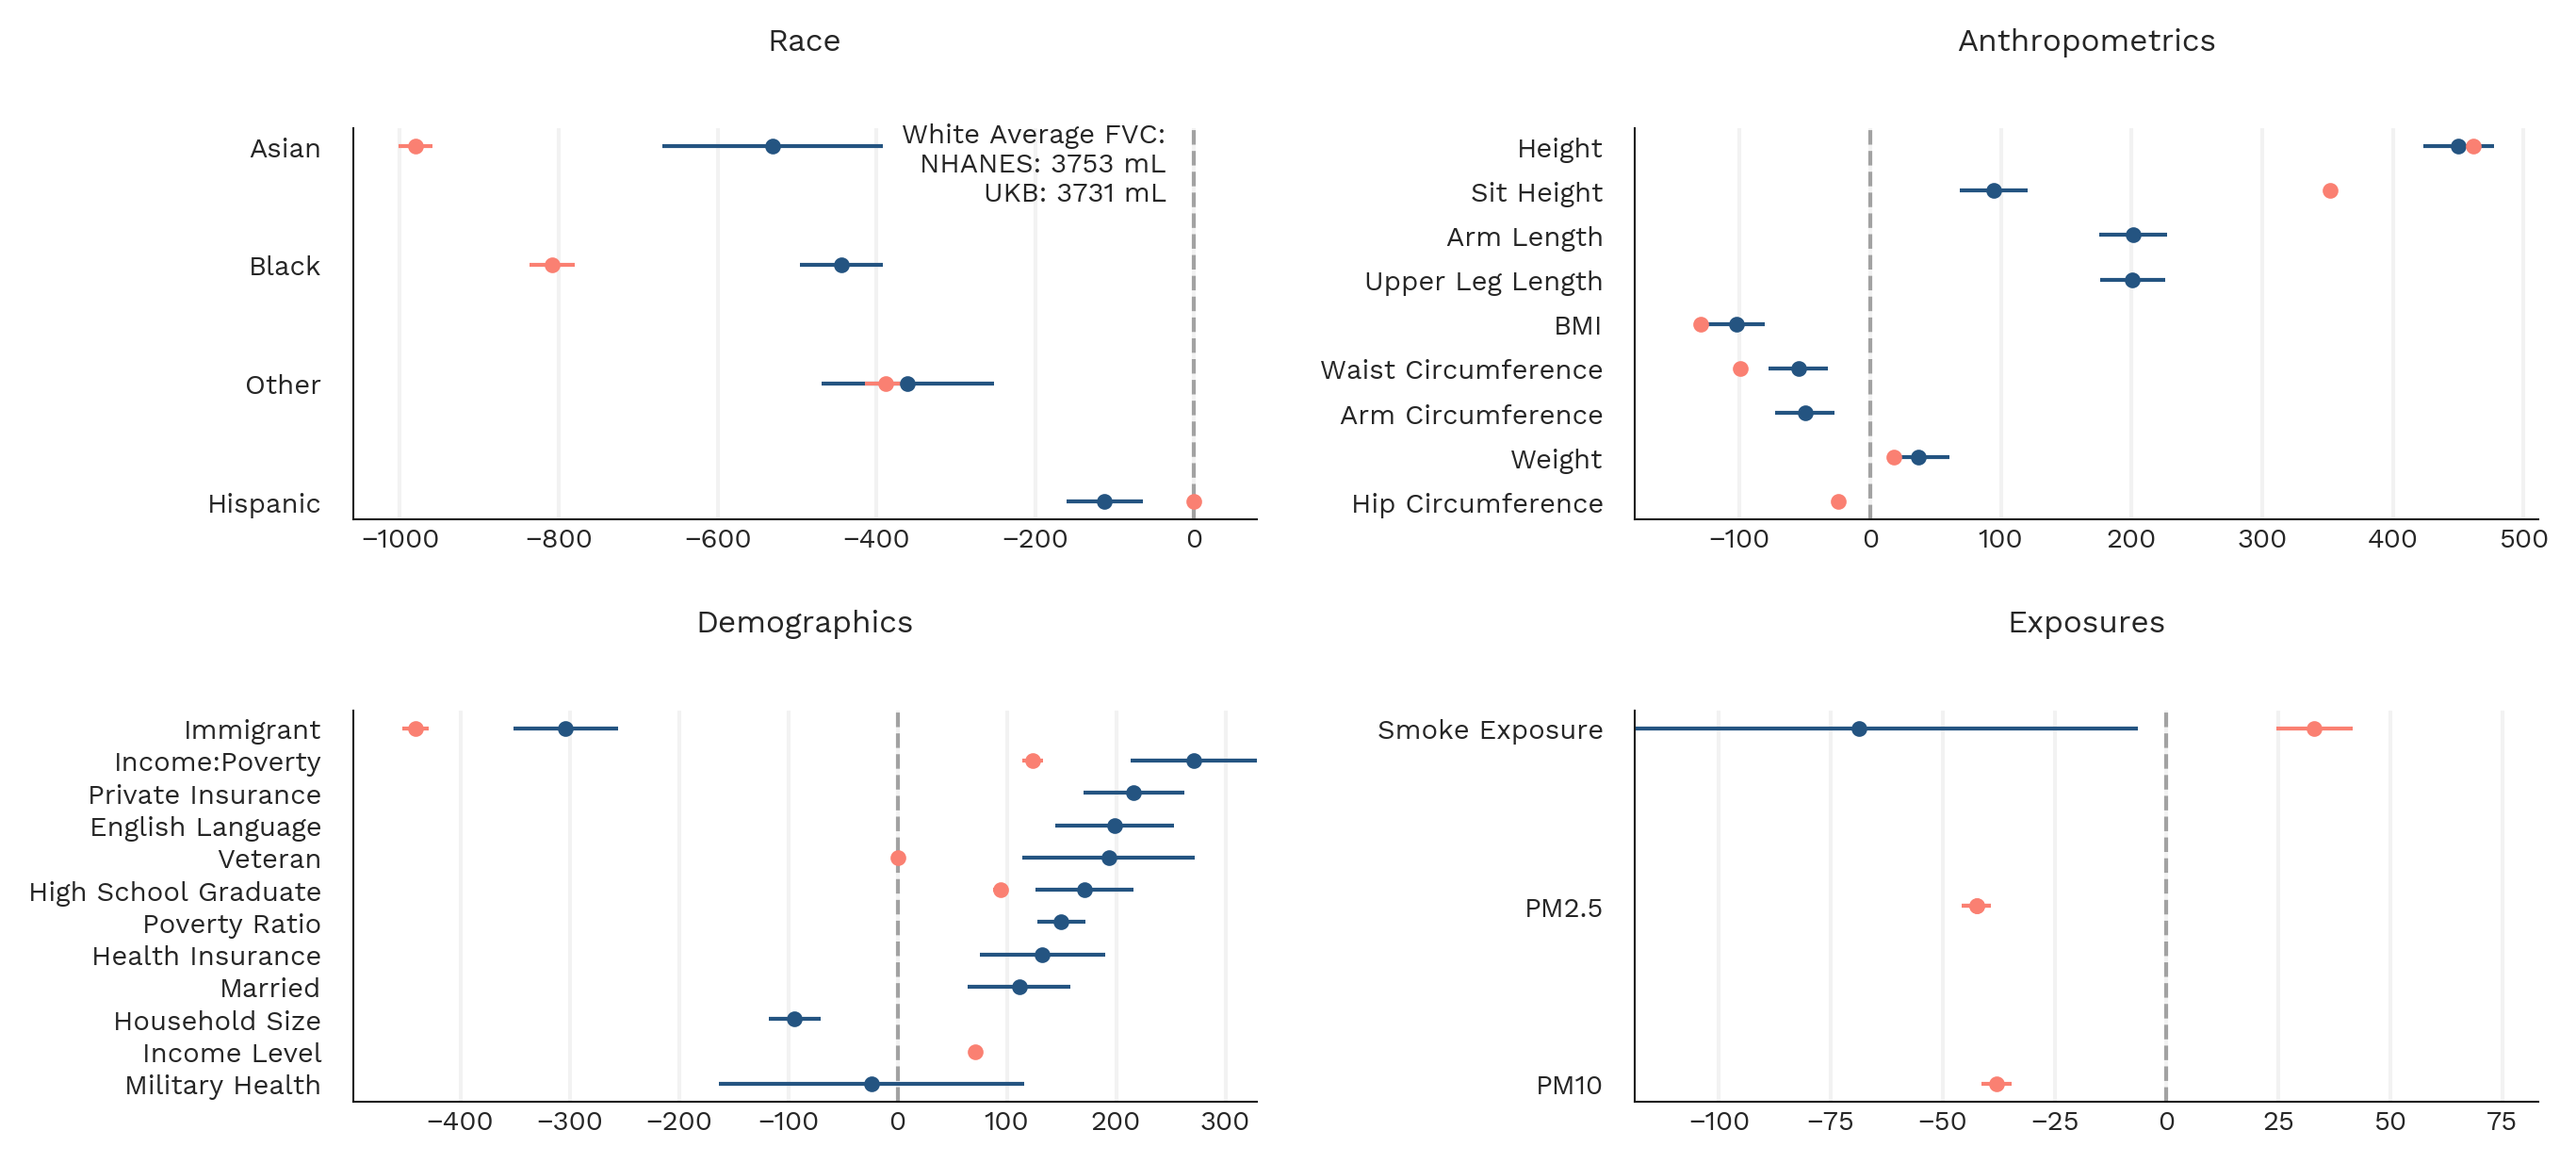

In [ ]:
def load_effects(data_dir, cohorts=("UKB", "NH"), targets=("FVC", "FEV1"),
                 groups=("Race", "Anthropometrics", "Demographics", "Exposures")):
    dfs = []
    for f in os.listdir(data_dir):
        dfs.append(pd.read_csv(os.path.join(data_dir, f)))
    df = pd.concat(dfs, ignore_index=True)

    df["target"] = df["target"].astype(str).str.upper()
    df["cohort"] = df["cohort"].astype(str)
    df["group"] = df["group"].astype(str)
    df["title"] = df["title"].astype(str)

    remove = ['Work Breathing Problems', 'Work Exhaust', 'Work Air']
    df = df[~df['title'].isin(remove)]
    return df.query("cohort in @cohorts and target in @targets and group in @groups").copy()


def forest_4panel(df, target="FVC", groups=("Race", "Anthropometrics", "Demographics", "Exposures"),
                  cohort_labels=None, 
                  figsize=(6, 1),
                  white_avg_note=None):
    d = df.query("target == @target").copy()
    cohorts = d.cohort.unique()

    cohort_labels = cohort_labels or {"UKB": "UKB", "NH": "NHANES", "NH3": "NH3", "NH4": "NH4"}
    # Define 3 unique colors for UKB and 3 shades for NH-based cohorts
    # Example UKB: purple shades, NH: blue shades (darker to lighter)
    cohort_colors = {
        "UKB": "salmon",    # primary UKB, salmon
        "NH": "#245481",       # main NH, a bold blue
        "NH3": "#4996ce",      # lighter blue for a NH child cohort
        "NH4": "#7fc7fa",      # lightest blue for another NH cohort
    }

    fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=300,
                             gridspec_kw={"hspace": 0.1, "wspace": 0.05})
    axs = axs.ravel()

    # Adjust spacing to make more room for titles and the legend
   # plt.subplots_adjust(top=0.85, hspace=0.9, wspace=0.5)
    for ax, g in zip(axs, groups):
        dg = d.query("group == @g").copy()
        dg = dg.sort_values("coef", ascending=True)
        dg = dg.assign(_abs=dg["coef"].abs()).sort_values("_abs", ascending=False)

        titles = dg["title"].drop_duplicates().tolist()
        y = np.arange(len(titles))
        y_map = {t: i for i, t in enumerate(titles)}

        for c in cohorts:
            dc = dg.query("cohort == @c")            
            x = dc["coef"].to_numpy()
            xerr = 1.96 * dc["std_err"].to_numpy()
            yy = dc["title"].map(y_map).to_numpy()

            ax.errorbar(
                x, yy, xerr=xerr,
                fmt="o", 
                color=cohort_colors[c],
                label=cohort_dict[c],
            )

        ax.axvline(0, ls="--", color="gray", alpha=0.7)
        ax.set_yticks(y)
        ax.set_yticklabels(titles)
        ax.invert_yaxis()
        ax.set_title(g, pad=20) 
        ax.grid(True, axis="x", alpha=0.25)

        pad = max(50, 0.08 * (dg["coef"].max() - dg["coef"].min()))
        ax.set_xlim(dg["coef"].min() - pad, dg["coef"].max() + pad)

        if g == "Race" and white_avg_note:
            ax.text(0.9, 0.8, white_avg_note, transform=ax.transAxes,
                    ha="right", va="bottom", fontsize=7)

    handles, labels = axs[0].get_legend_handles_labels()
    labels = [cohort_dict[l.lower()] for l in labels]
    if handles:
        # Place the legend higher so it doesn't overlap, and make more room if needed
        fig.legend(handles, labels, loc="upper center", ncol=len(labels),
                   frameon=False, bbox_to_anchor=(0.5, 1.05))

    fig.supxlabel(f"{target} Effect Size (mL)")
    return fig

cohorts = (["UKB", "NH3", "NH4"], ["UKB", "NH"])
for coh in cohorts:
    cohort_str = '_'.join([c.lower() for c in coh])
    save_path = f"../results/ewas/figures/coef_{cohort_str}"
    df = load_effects(data_dir, cohorts=coh)
    targets = ["FVC", "FEV1"]
    for target in targets:
        fig = forest_4panel(
            df,
            target=target,
            white_avg_note=f"White Average {target}:\nNHANES: 3753 mL\nUKB: 3731 mL",
            figsize=(9, 4),
        )
        plt.savefig(f"{save_path}_{target}.pdf", dpi=300)
        plt.show()